## Conversion csv to npz graph file

In [1]:
import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd

c:\Users\nino\anaconda4\envs\myenv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
import os
os.getcwd()

'c:\\Users\\nino\\Desktop\\Python\\ThesisFinal'

In [2]:
df = pd.read_csv('kc_house_data.csv')

In [7]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [10]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Convert datetime

In [16]:
df["date"]

0        20141013T000000
1        20141209T000000
2        20150225T000000
3        20141209T000000
4        20150218T000000
              ...       
21608    20140521T000000
21609    20150223T000000
21610    20140623T000000
21611    20150116T000000
21612    20141015T000000
Name: date, Length: 21613, dtype: object

In [3]:
df["date"] = pd.to_datetime(df["date"])
df["date"]

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21608   2014-05-21
21609   2015-02-23
21610   2014-06-23
21611   2015-01-16
21612   2014-10-15
Name: date, Length: 21613, dtype: datetime64[ns]

In [4]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

In [6]:
df = df.drop(["date"], axis=1)
df

KeyError: "['date'] not found in axis"

## MinMaxScaler

In [7]:
from sklearn.preprocessing import MinMaxScaler #The embedding models work when the values are in [0,1]. Need to check if it also works with a standardscaler and normalization.
excluded_cols = ["id", "price", "lat", "long"]
cols_to_scale = [col for col in df.columns if col not in excluded_cols]
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [8]:
df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,7129300520,221900.0,0.090909,0.12500,0.067170,0.003108,0.0,0.0,0.0,0.5,...,0.478261,0.000000,0.893939,47.5112,-122.257,0.161934,0.005742,0.0,0.818182,0.400000
1,6414100192,538000.0,0.090909,0.28125,0.172075,0.004072,0.4,0.0,0.0,0.5,...,0.443478,0.988089,0.626263,47.7210,-122.319,0.222165,0.008027,0.0,1.000000,0.266667
2,5631500400,180000.0,0.060606,0.12500,0.036226,0.005743,0.0,0.0,0.0,0.5,...,0.286957,0.000000,0.136364,47.7379,-122.233,0.399415,0.008513,1.0,0.090909,0.800000
3,2487200875,604000.0,0.121212,0.37500,0.126038,0.002714,0.0,0.0,0.0,1.0,...,0.565217,0.000000,0.681818,47.5208,-122.393,0.165376,0.004996,0.0,1.000000,0.266667
4,1954400510,510000.0,0.090909,0.25000,0.104906,0.004579,0.0,0.0,0.0,0.5,...,0.756522,0.000000,0.368687,47.6168,-122.045,0.241094,0.007871,1.0,0.090909,0.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,360000.0,0.090909,0.31250,0.093585,0.000370,0.8,0.0,0.0,0.5,...,0.947826,0.000000,0.515152,47.6993,-122.346,0.194631,0.000986,0.0,0.363636,0.666667
21609,6600060120,400000.0,0.121212,0.31250,0.152453,0.003206,0.4,0.0,0.0,0.5,...,0.991304,0.000000,0.732323,47.5107,-122.362,0.246257,0.007523,1.0,0.090909,0.733333
21610,1523300141,402101.0,0.060606,0.09375,0.055094,0.000503,0.4,0.0,0.0,0.5,...,0.947826,0.000000,0.722222,47.5944,-122.299,0.106866,0.001558,0.0,0.454545,0.733333
21611,291310100,400000.0,0.090909,0.31250,0.098868,0.001132,0.4,0.0,0.0,0.5,...,0.904348,0.000000,0.131313,47.5345,-122.069,0.173980,0.000731,1.0,0.000000,0.500000


## Create graph

In [10]:
import geopy
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import node_classification
from networkx.algorithms.community.centrality import girvan_newman

Create the graph based on the latitude and longitude coordinates of the csv file

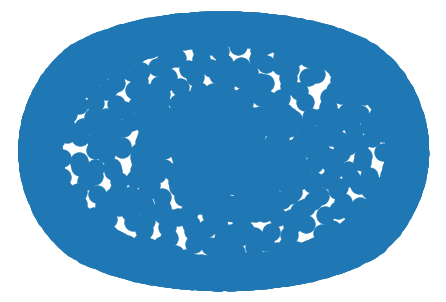

In [13]:
G = nx.Graph()
for index,row in df.iterrows():
    G.add_node(row["id"], pos=(row["lat"], row["long"]))
nx.draw(G)

Create edges based on a distance threshold delta, input given by user

In [15]:
from geopy.distance import distance

In [16]:
threshold = 500 # meters

# Loop over all pairs of nodes and add an edge if their distance is below the threshold
for u, u_data in G.nodes(data=True):
    for v, v_data in G.nodes(data=True):
        if u < v:
            u_pos = u_data['pos']
            v_pos = v_data['pos']
            dist = distance(u_pos, v_pos).m
            if dist <= threshold:
                G.add_edge(u, v, weight=dist)

KeyboardInterrupt: 

In [ ]:
nx.draw(G, node_size=10)

Graph needs to satisfy the following conditions
- It cannot have self-loops, in other words the diagonal of the adjacency matrix must contain zero values
- There cannot be any dangling nodes, every node needs to be connected in the graph

In [ ]:
# Check for self-loops
G.remove_edges_from(nx.selfloop_edges(G))

In [ ]:
import scipy.sparse as sp

In [ ]:
# Check for dangling nodes
has_dangling_nodes = sp.linalg.norm(sp.sparse.csr_matrix.sum(A, axis=1) - 1) > 1e-10

if has_dangling_nodes:
    print('The graph has dangling nodes')
else:
    print('The graph does not have dangling nodes')

## Create scipy sparce attribute matrix

In [ ]:
df_numpy = df.to_numpy()
attr_matrix = csr_matrix(df_numpy).astype("float32")
attr_matrix

## Create adjacency matrix

In [ ]:
A = nx.to_scipy_sparse_matrix(G).astype("float32")
A

# Check if this is above zero, if it is then there are self-loops left - which is not allowed
A.diagonal().sum()

## Save graph as npz file

The code of das et al includes labels if it's present, if it's not then label is set to "None".

Price is given separately in the code.

The code of das et al requires different POIs, so it has to be a heterogeneous graph. The attribute data needs to be in order according to this.

In [ ]:
np.savez('FINALEDUMMYDATASET.npz', edges = G.edges, adj_data=A.data, adj_indices=A.indices, adj_indptr=A.indptr,
         adj_shape=A.shape, attr_data=attr_matrix.data, attr_indices=attr_matrix.indices, attr_indptr=attr_matrix.indptr,
         attr_shape=attr_matrix.shape, labels=df["price"])